# Latent Dirichlet Allocation

![image](https://mollermara.com/blog/lda/lda-tikz.png)

Multinomial distribution
$p(x_1, ..., x_k) = \frac{n!}{x_1! ... x_k!} p_1^{x_1}...p_k^{x_k}$, where
$\sum_{i=1}^k x_i = n$


Dirichlet distribution
$Dir(x | \alpha) = \frac{1}{B(\alpha)} \prod_{i=1}^k x_i^{\alpha_i-1}$, where $\alpha_i > 0$


![image](http://cs.stanford.edu/~ppasupat/a9online/uploads/dp-dirichlet.png)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.externals import joblib
from sklearn import metrics
from tqdm import tqdm

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [8]:
A,terms,snippets = joblib.load("articles-tfidf.pkl")

## apply LDA

In [25]:
# create the model
k = 10
model = LatentDirichletAllocation(n_components=k, max_iter=5,
                                learning_method='batch',
                                learning_offset=50.,
                                random_state=1)

W = model.fit_transform( A )
H = model.components_

In [26]:
W.shape

(4551, 10)

In [27]:
W[0,:].round(2)

array([ 0.01,  0.92,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01])

In [28]:
H.shape

(10, 10285)

In [29]:
H[:,terms.index('brexit')].round(2)

array([  0.1 ,  67.76,   0.1 ,   0.1 ,   0.41,   0.1 ,   0.1 ,   0.1 ,
         0.1 ,   0.1 ])

In [30]:
# show topic descriptors
def get_descriptor( terms, H, topic_index, top ):
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: league, season, leicester, premier, goal, liverpool, ball, game, united, players
Topic 02: trump, eu, bank, uk, people, brexit, clinton, government, vote, campaign
Topic 03: promoter, prize, entries, tickets, barclays, winners, competition, details, n1, entry
Topic 04: vile, carrie, lawrence, affleck, congratulations, maternal, shrinking, plainly, tube, cliff
Topic 05: film, album, music, people, life, time, pop, band, song, songs
Topic 06: groping, gibson, owes, mel, congratulations, maternal, shrinking, plainly, tube, psychiatric
Topic 07: rhodes, lou, congratulations, maternal, shrinking, plainly, angels, tube, psychiatric, undeniable
Topic 08: shaun, sheep, wallace, der, originated, chairman, rip, burton, debuted, die
Topic 09: radiohead, lisbon, jonny, imminent, manuel, dividends, overhaul, tame, invoke, switzerland
Topic 10: yoga, bma, zac, junior, oddity, fred, doctors, tube, hunt, incorporated


In [31]:
def get_top_snippets( all_snippets, W, topic_index, top ):
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets

topic_snippets = get_top_snippets( snippets, W, 0, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. Christian Eriksen doubles up as Spurs ease to victory against Sunderland Before this game Sam Allard
02. Crystal Palace punish Swansea profligacy as Scott Dann grabs point Swansea City stretched their unbe
03. Mauricio Pochettino tells Tottenham fans to dream following win at City Mauricio Pochettino said Tot
04. Arsène Wenger’s referee complaints ridiculed by Ronald Koeman Ronald Koeman ridiculed Arsène Wenger 
05. Rafael Benítez aghast after Newcastle surrender meekly at Southampton Rafael Benítez was aghast at N
06. Jürgen Klopp says Liverpool cannot complain about defensive tactics Jürgen Klopp said Liverpool have
07. Manchester City will not give up title fight, says Manuel Pellegrini Manuel Pellegrini insists that 
08. Liverpool v West Bromwich Albion: match preview With Liverpool’s sights raised this season Jürgen Kl
09. Arsène Wenger: I am not in the mood to dream of Arsenal winning League Arsène Wenger has written off
10. Arsenal suffer ‘confidence issue’ as Petr Cech inju

## Topic Coherence

In [32]:
kmin, kmax = 4, 15

topic_models = []
for k in tqdm(range(kmin,kmax+1)):
    model = LatentDirichletAllocation(n_components=k, max_iter=5,
                                learning_method='batch',
                                learning_offset=50.,
                                random_state=1)
    W = model.fit_transform( A )
    H = model.components_    
    topic_models.append( (k,W,H) )

100%|██████████| 12/12 [02:07<00:00, 10.60s/it]


In [33]:
import gensim

w2v_model = gensim.models.Word2Vec.load("w2v-model.bin")
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 12192 terms


Calculate topic coherence TC-W2C as a mean pairwise similarity of words from topic. 

In [34]:
from itertools import combinations


def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=0.3924
K=05: Coherence=0.4297
K=06: Coherence=0.4234
K=07: Coherence=0.4103
K=08: Coherence=0.4735
K=09: Coherence=0.4438
K=10: Coherence=0.4035
K=11: Coherence=0.4706
K=12: Coherence=0.5705
K=13: Coherence=0.4176
K=14: Coherence=0.4844
K=15: Coherence=0.4889


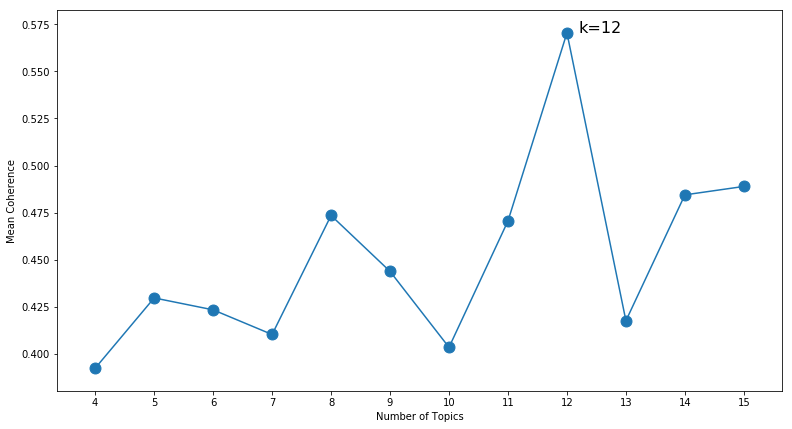

In [35]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [36]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: league, season, leicester, premier, goal, ball, liverpool, game, united, players
Topic 02: trump, eu, people, uk, brexit, time, health, government, clinton, bank
Topic 03: bank, rbs, deutsche, banks, shares, lloyds, barclays, banking, libor, taxpayer
Topic 04: superman, batman, prize, promoter, parker, gibson, entries, marvel, barclays, tickets
Topic 05: album, film, music, songs, pop, song, band, rock, love, festival
Topic 06: detective, sequences, immersive, orchestral, spins, acclaim, compile, premiered, inventive, revenant
Topic 07: halves, encore, angel, melancholy, exhilarating, detective, sequences, immersive, orchestral, spins
Topic 08: detective, sequences, immersive, orchestral, spins, acclaim, compile, premiered, inventive, revenant
Topic 09: detective, sequences, immersive, orchestral, spins, acclaim, compile, premiered, inventive, revenant
Topic 10: milner, lallana, firmino, sturridge, coutinho, mignolet, moreno, henderson, lucas, mané
Topic 11: detective, sequen

In [39]:
np.mean(H[5,:] - H[8,:])

-2.8952874506136589e-14

In [40]:
model.perp_tol

0.1